In [1]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
def set_length(audio, length):
    input_audio_length = len(audio)

    if input_audio_length > length:
        audio = audio[:length]
    elif input_audio_length < length:
        audio = np.append(audio, [0.0000000001] * (length - input_audio_length))
    return audio

In [3]:
def extract_features_from_audio(audio, frame_length=256, sr=8000, hop_length=128):

    # Calculate number of frames
    num_frames = 1 + (len(audio) - frame_length) // hop_length

    # Initialize lists to hold features
    mfccs = []
    zcr = []

    for i in range(num_frames):
        # Define the start and end of the frame
        start = i * hop_length
        end = start + frame_length
        
        # Extract the current frame
        frame = audio[start:end]

        # Apply Hamming window
        windowed_frame = frame * np.hamming(frame_length)

        # Extract MFCCs (13 coefficients)
        mfcc = librosa.feature.mfcc(y=windowed_frame, sr=sr, n_mfcc=13, n_fft=frame_length)
        mfccs.append(mfcc.flatten())  # Shape (13,)

        # Calculate ZCR (1 value)
        zcr_value = librosa.feature.zero_crossing_rate(windowed_frame)
        zcr.append(zcr_value.flatten())  # Shape (1,)

    # Convert lists to numpy arrays
    mfccs = np.array(mfccs)  # Shape: (N, 13)
    zcr = np.array(zcr)  # Shape: (N, 1)

    # Combine features: Shape (N, 14)
    features = np.hstack((mfccs, zcr))  # Shape: (N, 14)


    return features  # Shape: (N, 14)

In [4]:
def process_audio_files(base_dir, sr=8000, audio_length = 7680, max_files_per_class=float('inf')):
    # Path to the "digit audios" directory
    digit_audios_dir = os.path.join(base_dir, "audios")
    
    # Initialize lists to store features and labels
    all_features = []
    labels = []
    classes = []

    # Get and sort class names in the order "zero", "one", "two", ..., "nine"
    class_names = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

    # Loop through each class folder in the "digit audios" directory
    for class_index, class_name in enumerate(class_names):
        class_folder_path = os.path.join(digit_audios_dir, class_name)

        # Check if it is a directory
        if os.path.isdir(class_folder_path):
            classes.append(class_name)  # Store class name
            
            # Initialize a counter to keep track of files processed
            file_count = 0
            
            for audio_file in os.listdir(class_folder_path):
                file_path = os.path.join(class_folder_path, audio_file)
                
                # Check if the file is a valid audio file
                if os.path.isfile(file_path) and file_path.endswith(('.mp3', '.wav', '.flac')):
                    print(f"Processing file: {audio_file} in class: {class_name}")
                    # Load audio file with specified sampling rate
                    audio, _ = librosa.load(file_path, sr=sr)
                    audio = set_length(audio, audio_length)
                    audio = audio/abs(audio).max()          # Normalizing
                    features = extract_features_from_audio(audio)
                    
                    all_features.append(features)  # Append the features (shape: (N, 14))
                    labels.append(class_index)  # Add label for one-hot encoding

                    # Increment the file count and check against max_files_per_class
                    file_count += 1
                    if file_count >= max_files_per_class:
                        break  # Stop processing more files for this class
    # Stack all feature matrices into a single array

    # all_features_matrix = np.vstack(all_features)  # Shape: (total_frames, 14)
    final_features_matrix = np.array(all_features).transpose(0, 2, 1)

    # Create one-hot encoded labels
    num_classes = len(classes)
    one_hot_labels = np.zeros((len(labels), num_classes))

    print('Labels are:', labels)
    print('Number of classes is:', num_classes)

    for i, label in enumerate(labels):
        one_hot_labels[i, label] = 1

    return final_features_matrix, one_hot_labels, classes  # Shape: (num_files, 14, total_frames)

In [5]:
current_dir = os.getcwd()
features_matrix, one_hot_labels, classes = process_audio_files(current_dir)

print("Feature extraction completed.")
print(f"Feature matrix shape: {features_matrix.shape}")  # Should print (num_files, 14, total_frames)
print(f"One-Hot Encoded Labels:\n {one_hot_labels}")
print(f"Classes: {classes}")

Processing file: zero_1.wav in class: zero
Processing file: zero_10.wav in class: zero
Processing file: zero_11.wav in class: zero
Processing file: zero_12.wav in class: zero
Processing file: zero_2.wav in class: zero
Processing file: zero_3.wav in class: zero
Processing file: zero_4.wav in class: zero
Processing file: zero_5.wav in class: zero
Processing file: zero_6.wav in class: zero
Processing file: zero_7.wav in class: zero
Processing file: zero_8.wav in class: zero
Processing file: zero_9.wav in class: zero
Processing file: one_1.wav in class: one
Processing file: one_10.wav in class: one
Processing file: one_11.wav in class: one
Processing file: one_12.wav in class: one
Processing file: one_2.wav in class: one
Processing file: one_3.wav in class: one
Processing file: one_4.wav in class: one
Processing file: one_5.wav in class: one
Processing file: one_6.wav in class: one
Processing file: one_7.wav in class: one
Processing file: one_8.wav in class: one
Processing file: one_9.wav 

In [6]:
_, num_features, sequence_length = features_matrix.shape
scaler = StandardScaler()
# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    features_matrix,
    one_hot_labels,
    test_size=0.2,  # 20% for testing
    random_state=1,  # For reproducibility
    stratify=one_hot_labels
)
total_training_examples = X_train.shape[0]
total_testing_examples = X_test.shape[0]
temp = X_train.transpose(0, 2, 1).reshape(-1, num_features)
scaler.fit(temp)
temp = scaler.transform(temp)
X_train = temp.reshape(total_training_examples, sequence_length, num_features)
temp = X_test.transpose(0, 2, 1).reshape(-1, num_features)
temp = scaler.transform(temp)
X_test = temp.reshape(total_testing_examples, sequence_length, num_features)

In [7]:
class AdamOptimizer:
    def __init__(self, alpha, params, beta1=0.9, beta2=0.999, epsilon=10e-8):
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.moments = []
        self.epoch = 0
        if not params:
            raise Exception("Parameters can't be undefined!")
        for i in range(len(params)):
            self.moments.append(
                {
                    'V': np.zeros_like(params[i]),
                    'S': np.zeros_like(params[i])
                }
            )

    def update(self, params=[], grads=[]):
        params_len = len(params)
        grads_len = len(grads)
        if params_len != grads_len or params_len == 0:
            raise Exception("Empty or Inconsistant Parameters and Gradients List!")

        self.epoch += 1

        for i in range(grads_len):
            # Update biased first moment estimate
            self.moments[i]['V'] = self.beta1 * self.moments[i]['V'] + (1 - self.beta1) * grads[i]
            # Update biased second raw moment estimate (RMSProp part)
            self.moments[i]['S'] = self.beta2 * self.moments[i]['S'] + (1 - self.beta2) * np.square(grads[i])
            # Compute bias-corrected first moment estimate
            VdW_corrected = self.moments[i]['V'] / (1 - self.beta1 ** self.epoch)
            # Compute bias-corrected second raw moment estimate (RMSProp part)
            SdW_corrected = self.moments[i]['S'] / (1 - self.beta2 ** self.epoch)
            # Update parameters
            params[i] -= self.alpha * VdW_corrected / (np.sqrt(SdW_corrected) + self.epsilon)
        
        return params

In [ ]:
class GRU:
    '''
    Specifications:
        * Only contains single GRU layer
        * GRU Layer Activation Function: tanh
    '''
    def __init__(self, units, seq_len, total_classes, total_features=None, embedding_matrix=None, lr=0.1):
        self.embedding_matrix = embedding_matrix
        self.lr = lr
        self.seq_len = seq_len
        self.total_classes = total_classes
        if self.embedding_matrix is not None:
            self.total_features = self.embedding_matrix.shape[1]
            self.get_input_matrix = self.get_input_matrix_from_embedding_matrix
        else:
            if not total_features:
                raise Exception("Define total features!")
            self.total_features = total_features
            self.get_input_matrix = self.get_input_matrix_from_3d_input
        self.out_vals = 1 if self.total_classes == 2 else self.total_classes
        self.units = units
        self.reset_weights_biases() # Initializing Weights and Biases
        if self.out_vals == 1:
            self.calc_loss = self.calc_bce
            self.calc_accuracy = self.calc_accuracy_for_bin_classification
            self.out_func = self.sigmoid
            self.loss = 'BCE'
        else:
            self.calc_loss = self.calc_cce
            self.calc_accuracy = self.calc_accuracy_for_mult_class_classification
            self.out_func = self.softmax
            self.loss = 'CCE'
        
        self.epoch = 0
    
    def sigmoid(self, z):
        return (1/(1+np.exp(-z)))
    
    def softmax(self, Z):
        num = np.exp(Z)
        den = np.sum(num, axis=0)
        return num/den
    
    def diag(self, array):
        flat_array = array.flatten()
        return np.diag(flat_array)
    
    def get_input_matrix_from_3d_input(self, input, idx):
        return input[idx, :, :]
    
    def get_input_matrix_from_embedding_matrix(self, input, idx):
        return self.embedding_matrix[input[idx,:]].T
    
    def predict(self, input):
        if input.ndim == 3:
            input = input.transpose(1, 2, 0)
        else:
            input = input.T
        total_input_examples = input.shape[-1]
        A = np.zeros((self.units, total_input_examples))
        Z = np.zeros_like(A)
        R = np.zeros_like(A)
        Ac = np.zeros_like(A)
        for seq_len_idx in range(self.seq_len):
            input_matrix = self.get_input_matrix(input, idx=seq_len_idx)    #Dim: total_features x M
            Z = self.sigmoid(self.W_iz.T @ input_matrix + self.W_hz @ A + self.b_z)
            R = self.sigmoid(self.W_ir.T @ input_matrix + self.W_hr @ A + self.b_r)
            Ac = np.tanh ( R * (self.W_h @ A) + self.W_i.T @ input_matrix + self.b_h )
            A = (1 - Z) * Ac + Z * A
        return self.out_func( self.w_o.T @ A + self.b_o ).T
    
    def forward_prop(self, input, return_pred=True):
        total_input_examples = input.shape[-1]
        self.A = np.zeros((self.seq_len+1, self.units, total_input_examples))
        self.Z = np.zeros((self.seq_len, self.units, total_input_examples))
        self.R = np.zeros_like(self.Z)
        self.Ac = np.zeros_like(self.Z)
        for seq_len_idx in range(self.seq_len):
            input_matrix = self.get_input_matrix(input, idx=seq_len_idx)    #Dim: total_features x M
            self.Z[seq_len_idx] = self.sigmoid(self.W_iz.T @ input_matrix + self.W_hz @ self.A[seq_len_idx] + self.b_z)
            self.R[seq_len_idx] = self.sigmoid(self.W_ir.T @ input_matrix + self.W_hr @ self.A[seq_len_idx] + self.b_r)
            self.Ac[seq_len_idx] = np.tanh ( self.R[seq_len_idx] * (self.W_h @ self.A[seq_len_idx]) + self.W_i.T @ input_matrix + self.b_h )
            self.A[seq_len_idx+1] = (1 - self.Z[seq_len_idx]) * self.Ac[seq_len_idx] + self.Z[seq_len_idx] * self.A[seq_len_idx]
        if return_pred:
            return self.out_func( self.w_o.T @ self.A[-1] + self.b_o )
        return
    
    def backward_prop(self, input, true_labels):
        dL_by_db_o = np.zeros((self.out_vals, 1))
        dL_by_dw_o = np.zeros((self.units, self.out_vals))
        dL_by_db_z = np.zeros((self.units, 1))
        dL_by_dW_iz = np.zeros((self.total_features, self.units))
        dL_by_dW_hz = np.zeros((self.units, self.units))
        dL_by_db_r = np.zeros((self.units, 1))
        dL_by_dW_ir = np.zeros((self.total_features, self.units))
        dL_by_dW_hr = np.zeros((self.units, self.units))
        dL_by_db_h = np.zeros((self.units, 1))
        dL_by_dW_i = np.zeros((self.total_features, self.units))
        dL_by_dW_h = np.zeros((self.units, self.units))
        y_pred = self.out_func( self.w_o.T @ self.A[-1] + self.b_o )
        temp_1 = y_pred - true_labels
        # b_o
        dL_by_db_o += np.sum(temp_1, axis=1).reshape(self.out_vals, 1)
        # w_o
        dL_by_dw_o += self.A[-1] @ temp_1.T
        temp_1 = self.w_o @ temp_1  # Dim: hxM
        # b_z
        hold = temp_1 * (self.A[-2] - self.Ac[-1]) * (self.Z[-1] * (1 - self.Z[-1]))
        dL_by_db_z += np.sum(hold, axis=1).reshape(self.units, 1)
        input_matrix = self.get_input_matrix(input, idx=-1)
        # W_iz
        dL_by_dW_iz += input_matrix @ hold.T
        # W_hz
        dL_by_dW_hz += hold @ self.A[-2].T
        # b_h
        temp_2 = temp_1 * (1 - self.Z[-1])
        hold = temp_2 * (1 - np.square(self.Ac[-1]))
        dL_by_db_h += np.sum(hold, axis=1).reshape(self.units, 1)
        # W_i
        dL_by_dW_i += input_matrix @ hold.T # Dim: total_features x units   # First word of sequence
        # W_h
        dL_by_dW_h += (hold * self.R[-1]) @ self.A[-2].T # Dim: units x units
        # b_r
        hold = hold * (self.W_h @ self.A[-2]) * (self.R[-1] * (1 - self.R[-1]))
        dL_by_db_r += np.sum(hold, axis=1).reshape(self.units, 1)
        # W_ir
        dL_by_dW_ir += input_matrix @ hold.T
        # W_hr
        dL_by_dW_hr += hold @ self.A[-2].T

        for seq_len_idx in range(1, self.seq_len):
            temp_1 = temp_1 * self.Z[-seq_len_idx]
            input_matrix = self.get_input_matrix(input, idx=-seq_len_idx-1)
            # b_z
            hold = temp_1 * (self.A[-seq_len_idx-2] - self.Ac[-seq_len_idx-1]) * (self.Z[-seq_len_idx-1] * (1 - self.Z[-seq_len_idx-1]))
            dL_by_db_z += np.sum(hold, axis=1).reshape(self.units, 1)
            # W_iz
            dL_by_dW_iz += input_matrix @ hold.T
            # W_hz
            dL_by_dW_hz += hold @ self.A[-seq_len_idx-2].T
            # b_h
            temp_2 = temp_1 * (1 - self.Z[-seq_len_idx-1])
            hold = temp_2 * (1 - np.square(self.Ac[-seq_len_idx-1]))
            dL_by_db_h += np.sum(hold, axis=1).reshape(self.units, 1)
            # W_i
            dL_by_dW_i += input_matrix @ hold.T # Dim: total_features x units   
            # W_h
            dL_by_dW_h += (hold * self.R[-seq_len_idx-1]) @ self.A[-seq_len_idx-2].T # Dim: units x units
            # b_r
            hold = hold * (self.W_h @ self.A[-seq_len_idx-2]) * (self.R[-seq_len_idx-1] * (1 - self.R[-seq_len_idx-1]))
            dL_by_db_r += np.sum(hold, axis=1).reshape(self.units, 1)
            # W_ir
            dL_by_dW_ir += input_matrix @ hold.T
            # W_hr
            dL_by_dW_hr += hold @ self.A[-seq_len_idx-2].T
        return dL_by_db_o, dL_by_dw_o, dL_by_db_z, dL_by_dW_iz, dL_by_dW_hz, dL_by_db_r, dL_by_dW_ir, dL_by_dW_hr, dL_by_db_h, dL_by_dW_i, dL_by_dW_h

    def update_w_sgd(self, batch_size, dL_by_db_o, dL_by_dw_o, dL_by_db_z, dL_by_dW_iz, dL_by_dW_hz, dL_by_db_r, dL_by_dW_ir, dL_by_dW_hr, dL_by_db_h, dL_by_dW_i, dL_by_dW_h):
        norm_1 = 1/(batch_size)
        norm_2 = norm_1 / self.seq_len
        self.w_o -= self.lr * norm_1 * dL_by_dw_o
        self.b_o -= self.lr * norm_1 * dL_by_db_o
        self.b_z -= self.lr * norm_2 * dL_by_db_z
        self.W_iz -= self.lr * norm_2 * dL_by_dW_iz
        self.W_hz -= self.lr * norm_2 * dL_by_dW_hz
        self.b_r -= self.lr * norm_2 * dL_by_db_r
        self.W_ir -= self.lr * norm_2 * dL_by_dW_ir
        self.W_hr -= self.lr * norm_2 * dL_by_dW_hr
        self.b_h -= self.lr * norm_2 * dL_by_db_h
        self.W_i -= self.lr * norm_2 * dL_by_dW_i
        self.W_h -= self.lr * norm_2 * dL_by_dW_h
        return
    
    def update_w_adam_optimizer(self, batch_size, dL_by_db_o, dL_by_dw_o, dL_by_db_z, dL_by_dW_iz, dL_by_dW_hz, dL_by_db_r, dL_by_dW_ir, dL_by_dW_hr, dL_by_db_h, dL_by_dW_i, dL_by_dW_h):
        norm_1 = 1/(batch_size)
        norm_2 = norm_1 / self.seq_len

        dL_by_db_o *= norm_1
        dL_by_dw_o *= norm_1
        dL_by_db_z *= norm_2
        dL_by_dW_iz *= norm_2
        dL_by_dW_hz *= norm_2
        dL_by_db_r *= norm_2
        dL_by_dW_ir *= norm_2
        dL_by_dW_hr *= norm_2
        dL_by_db_h *= norm_2
        dL_by_dW_i *= norm_2
        dL_by_dW_h *= norm_2
        self.b_o, self.w_o, self.b_z, self.W_iz, self.W_hz, self.b_r, self.W_ir, self.W_hr, self.b_h, self.W_i, self.W_h = self.optimizer.update(params=[self.b_o, self.w_o, self.b_z, self.W_iz, self.W_hz, self.b_r, self.W_ir, self.W_hr, self.b_h, self.W_i, self.W_h], grads=[dL_by_db_o, dL_by_dw_o, dL_by_db_z, dL_by_dW_iz, dL_by_dW_hz, dL_by_db_r, dL_by_dW_ir, dL_by_dW_hr, dL_by_db_h, dL_by_dW_i, dL_by_dW_h])
        return

    def reset_weights_biases(self):
        self.b_o = np.zeros((self.out_vals, 1))
        self.w_o = np.random.randn(self.units, self.out_vals) * np.sqrt(2 / (self.units + self.out_vals))
        self.b_z = np.zeros((self.units, 1))
        self.W_iz = np.random.randn(self.total_features, self.units) * np.sqrt(2 / (self.total_features + self.units))
        self.W_hz = np.random.randn(self.units, self.units) * np.sqrt(2 / (self.units + self.units))
        self.b_r = np.zeros((self.units, 1))
        self.W_ir = np.random.randn(self.total_features, self.units) * np.sqrt(2 / (self.total_features + self.units))
        self.W_hr = np.random.randn(self.units, self.units) * np.sqrt(2 / (self.units + self.units))
        self.b_h = np.zeros((self.units, 1))
        self.W_i = np.random.randn(self.total_features, self.units) * np.sqrt(2 / (self.total_features + self.units))
        self.W_h = np.random.randn(self.units, self.units) * np.sqrt(2 / (self.units + self.units))

    def calc_bce(self, y_pred, true_label):
        # Calculate the BCE for each example
        loss = - (true_label * np.log(y_pred) + (1 - true_label) * np.log(1 - y_pred))
        
        # Return the total loss (sum of all individual losses)
        return np.sum(loss)
        
    def calc_cce(self, y_pred, true_label):
        # Clip y_pred to avoid log(0) and very small values that may cause numerical instability
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        
        # Calculate the categorical cross-entropy for each example
        cce = -np.sum(true_label * np.log(y_pred), axis=0)
        
        # Calculate the mean loss over all examples
        total_loss = np.sum(cce)
        
        return total_loss
    
    def calc_accuracy_for_bin_classification(self, true_labels, predictions):
        wrong_decisions = np.sum( ((predictions <= 0.5) & (true_labels == 1)) | ((predictions > 0.5) & (true_labels == 0)) )
        total_examples = true_labels.shape[1]
        accuracy = (total_examples-wrong_decisions)/total_examples * 100
        return accuracy
    
    def calc_accuracy_for_mult_class_classification(self, true_labels, predictions):
        pred_indices = np.argmax(predictions, axis=0)
        true_indices = np.argmax(true_labels, axis=0)
        wrong_decisions = np.sum(pred_indices != true_indices)
        total_examples = true_indices.size
        accuracy = (total_examples-wrong_decisions)/total_examples * 100
        return accuracy
    
    def evaluate(self, X, labels, reshape=True):
        if reshape:
            if X.ndim == 3:
                X = X.transpose(1, 2, 0)
            else:
                X = X.T
            labels = labels.T
        # Check if the array is 1D
        if labels.ndim == 1:
            # Reshape to a column vector with shape (x, 1)
            labels = labels.reshape(1, labels.size)
        predictions = self.forward_prop(X)
        loss = self.calc_loss(predictions, labels)
        loss *= 1/X.shape[-1]
        accuracy = self.calc_accuracy(labels, predictions)

        return accuracy.item(), loss.item()
        
    def train(self, X_train, y_train, X_test, y_test, epochs, resume=False, verbose=True, adam_optimizer=False):
        if X_train.ndim == 3:
            X_train = X_train.transpose(1, 2, 0)
            X_test = X_test.transpose(1, 2, 0)
        else:
            X_train = X_train.T
            X_test = X_test.T
        y_train = y_train.T
        y_test = y_test.T
        if adam_optimizer:
            self.update = self.update_w_adam_optimizer
            self.optimizer = AdamOptimizer(self.lr, params=[self.b_o, self.w_o, self.b_z, self.W_iz, self.W_hz, self.b_r, self.W_ir, self.W_hr, self.b_h, self.W_i, self.W_h])
        else:
            self.update = self.update_w_sgd
        if not resume:
            self.epoch = 0
            self.reset_weights_biases()

        total_training_examples = X_train.shape[-1]
        epoch_idx = 0
        training_ds_loss_history = []
        testing_ds_loss_history = []
        while epoch_idx < epochs:
            epoch_idx += 1
            self.epoch +=1 
            self.forward_prop(X_train, return_pred=False)
            dL_by_db_o, dL_by_dw_o, dL_by_db_z, dL_by_dW_iz, dL_by_dW_hz, dL_by_db_r, dL_by_dW_ir, dL_by_dW_hr, dL_by_db_h, dL_by_dW_i, dL_by_dW_h = self.backward_prop(X_train, y_train)
            self.update(total_training_examples, dL_by_db_o, dL_by_dw_o, dL_by_db_z, dL_by_dW_iz, dL_by_dW_hz, dL_by_db_r, dL_by_dW_ir, dL_by_dW_hr, dL_by_db_h, dL_by_dW_i, dL_by_dW_h)
            if verbose:
                training_ds_accuracy, training_ds_loss = self.evaluate(X_train, y_train, reshape=False)
                testing_ds_accuracy, testing_ds_loss = self.evaluate(X_test, y_test, reshape=False)
                training_ds_loss_history.append(training_ds_loss)
                testing_ds_loss_history.append(testing_ds_loss)
                print(f"Epoch {self.epoch:03d} | "
                      f"Train Accuracy: {training_ds_accuracy:.2f}% | Train Loss ({self.loss}): {training_ds_loss:.4f} | "
                      f"Test Accuracy: {testing_ds_accuracy:.2f}% | Test Loss ({self.loss}): {testing_ds_loss:.4f}\n")
        return training_ds_loss_history, testing_ds_loss_history

In [70]:
gru = GRU(units=64, seq_len=sequence_length, total_features=num_features, lr=0.001, total_classes=10)

In [71]:
training_ds_loss_history, testing_ds_loss_history = gru.train(X_train, y_train, X_test, y_test, 200, adam_optimizer=True)

Epoch 001 | Train Accuracy: 10.42% | Train Loss (CCE): 2.3530 | Test Accuracy: 8.33% | Test Loss (CCE): 2.3793

Epoch 002 | Train Accuracy: 10.42% | Train Loss (CCE): 2.3304 | Test Accuracy: 8.33% | Test Loss (CCE): 2.3567

Epoch 003 | Train Accuracy: 10.42% | Train Loss (CCE): 2.3126 | Test Accuracy: 8.33% | Test Loss (CCE): 2.3375

Epoch 004 | Train Accuracy: 10.42% | Train Loss (CCE): 2.2990 | Test Accuracy: 8.33% | Test Loss (CCE): 2.3211

Epoch 005 | Train Accuracy: 10.42% | Train Loss (CCE): 2.2889 | Test Accuracy: 8.33% | Test Loss (CCE): 2.3074

Epoch 006 | Train Accuracy: 10.42% | Train Loss (CCE): 2.2817 | Test Accuracy: 8.33% | Test Loss (CCE): 2.2957

Epoch 007 | Train Accuracy: 10.42% | Train Loss (CCE): 2.2766 | Test Accuracy: 8.33% | Test Loss (CCE): 2.2857

Epoch 008 | Train Accuracy: 17.71% | Train Loss (CCE): 2.2729 | Test Accuracy: 12.50% | Test Loss (CCE): 2.2770

Epoch 009 | Train Accuracy: 18.75% | Train Loss (CCE): 2.2700 | Test Accuracy: 16.67% | Test Loss (CCE)

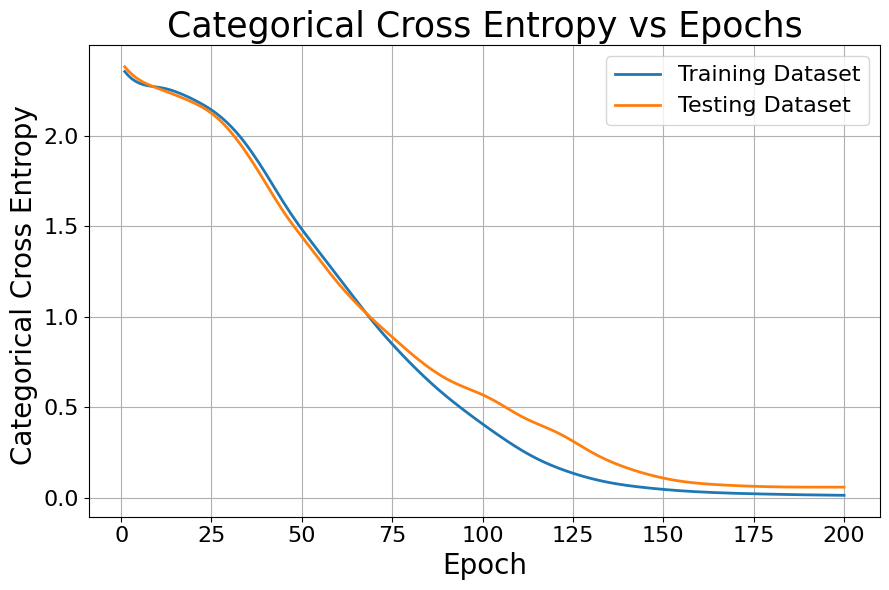

In [ ]:
iterations = np.arange(1, len(training_ds_loss_history)+1)
plt.figure(figsize=(9, 6))
plt.plot(iterations, training_ds_loss_history, linewidth=2, label='Training Dataset')
plt.plot(iterations, testing_ds_loss_history, linewidth=2, label='Testing Dataset')
plt.title('Categorical Cross Entropy vs Epochs', fontsize=25)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Categorical Cross Entropy ', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=16)
# plt.savefig('cce_gru.png', dpi=300)
plt.show()

In [74]:
accuracy_train, bce_train = gru.evaluate(X_train, y_train)
print(f"Training Dataset Accuracy: {accuracy_train:.2f}% | Training Dataset Loss (CCE): {bce_train:.4f}")

Training Dataset Accuracy: 100.00% | Training Dataset Loss (CCE): 0.0148


In [75]:
accuracy_test, bce_test = gru.evaluate(X_test, y_test)
print(f"Testing Dataset Accuracy: {accuracy_test:.2f}% | Testing Dataset Loss (CCE): {bce_test:.4f}")

Testing Dataset Accuracy: 100.00% | Testing Dataset Loss (CCE): 0.0598


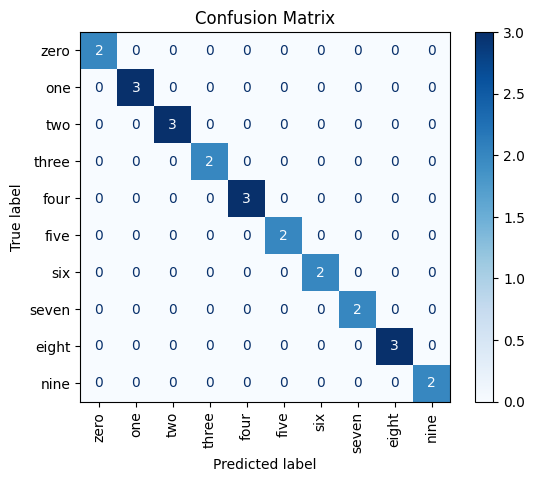

In [76]:
# Make predictions using the trained model
y_test_class = np.argmax(y_test, axis=1)
y_pred_prob = gru.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test_class, y_pred)

# Plot the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.savefig('cm_gru', dpi=300)
plt.show()

In [77]:
# Generating classification report from scikit-learn
cr = classification_report(y_test_class, y_pred)
print('Classification Report\n\n', cr)

Classification Report

               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         2

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

